<a href="https://colab.research.google.com/github/TaraRasti/Deep_Learning_F20_Project/blob/master/Notebooks/Final/Very%20Final/Final_Alzheimer(0_3valid)_vgg19_0_96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from collections import defaultdict

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform = transforms.Compose( [                                  
                                 transforms.Resize((224,224)),
                                 transforms.RandomRotation(10),
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(),
                                  ])

def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder('/content/drive/MyDrive/all/alldata', transform=transform)
print('length of dataset :',len(dataset))
datasets = train_val_dataset(dataset)
print('length of trainset :',len(datasets['train']))
print('length of validation set :',len(datasets['val']))
print(dataset)

length of dataset : 6400
length of trainset : 4480
length of validation set : 1920
Dataset ImageFolder
    Number of datapoints: 6400
    Root location: /content/drive/MyDrive/all/alldata
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
dataloaders = {x:DataLoader(datasets[x], 16, shuffle=True, num_workers=4) for x in ['train','val']}

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape, classes.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [ ]:
class_names = dataset.classes
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
dataset_sizes={'val':len(datasets['val']),'train':len(datasets['train'])}

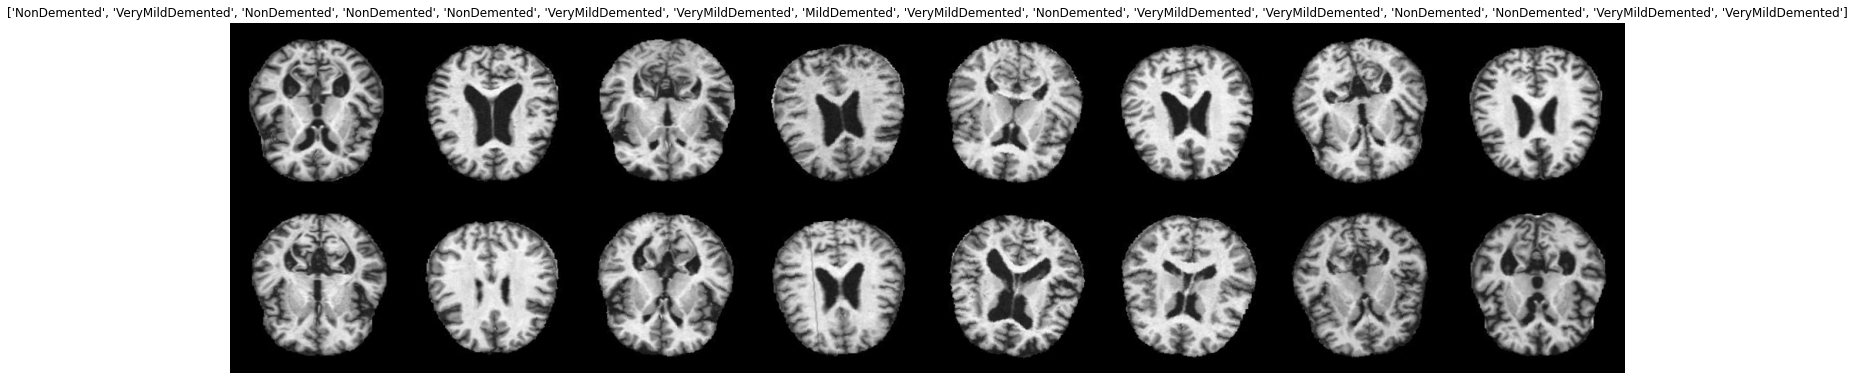

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(25, 25))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training)

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['val'])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders['val']):
        if i % 10 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data).item()

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['val']
    avg_acc = acc_test / dataset_sizes['val']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)


In [ ]:
vgg19 = models.vgg19(pretrained=True)
print(vgg19.classifier[6].out_features)  


for param in vgg19.features.parameters():
    param.require_grad = False


num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
vgg19.classifier = nn.Sequential(*features)
print(vgg19)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [ ]:
if use_gpu:
    vgg19.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(vgg19.parameters(), lr=1e-4, weight_decay=1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print("Test before training")
eval_model(vgg19, criterion)

Test before training
Evaluating model
----------
Test batch 110/120
Evaluation completed in 0m 12s
Avg loss (test): 0.0815
Avg acc (test): 0.4786
----------


In [ ]:
history = defaultdict(list)

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    val_batches = len(dataloaders['val'])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders['train']):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            if i >= train_batches:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()

        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders['val']):
            if i % 10 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data).item()

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes['val']
        avg_acc_val = acc_val / dataset_sizes['val']
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        history['epoch'].append(epoch+1)
        history['avg_loss'].append(round(avg_loss,5))
        history['avg_acc'].append(round(avg_acc,5))
        history['avg_loss_val'].append(round(avg_loss_val,5))
        history['avg_acc_val'].append(round(avg_acc_val,5))
    
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [ ]:
def plot_results(history):
    avg_acc = history['avg_acc']
    avg_acc_val = history['avg_acc_val']
    avg_loss = history['avg_loss']
    avg_loss_val = history['avg_loss_val']
    epochs = history['epoch']

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, avg_acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, avg_acc_val, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')  
    
    plt.subplot(1,2,2)
    plt.plot(epochs, avg_loss, 'b', label = 'Training Loss')
    plt.plot(epochs, avg_loss_val, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

In [ ]:
vgg19 = train_model(vgg19, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/30
----------
Training batch 270/280
Validation batch 110/120
Epoch 0 result: 
Avg loss (train): 0.0664
Avg acc (train): 0.4703
Avg loss (val): 0.0650
Avg acc (val): 0.5062
----------

Epoch 1/30
----------
Training batch 270/280
Validation batch 110/120
Epoch 1 result: 
Avg loss (train): 0.0636
Avg acc (train): 0.4911
Avg loss (val): 0.0660
Avg acc (val): 0.5062
----------

Epoch 2/30
----------
Training batch 270/280
Validation batch 110/120
Epoch 2 result: 
Avg loss (train): 0.0592
Avg acc (train): 0.5275
Avg loss (val): 0.0556
Avg acc (val): 0.5693
----------

Epoch 3/30
----------
Training batch 270/280
Validation batch 110/120
Epoch 3 result: 
Avg loss (train): 0.0557
Avg acc (train): 0.5589
Avg loss (val): 0.0556
Avg acc (val): 0.5682
----------

Epoch 4/30
----------
Training batch 270/280
Validation batch 110/120
Epoch 4 result: 
Avg loss (train): 0.0532
Avg acc (train): 0.5837
Avg loss (val): 0.0529
Avg acc (val): 0.5859
----------

Epoch 5/30
----------
Training batc

In [ ]:
eval_model(vgg19, criterion)

Evaluating model
----------
Test batch 110/120
Evaluation completed in 0m 12s
Avg loss (test): 0.0073
Avg acc (test): 0.9630
----------


Ground truth:


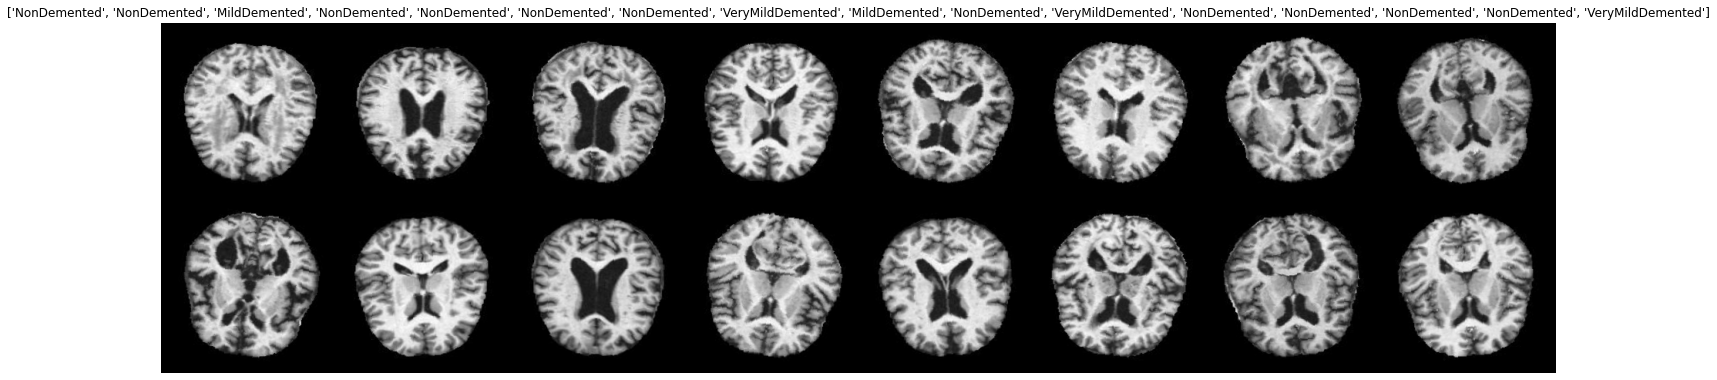

Prediction:


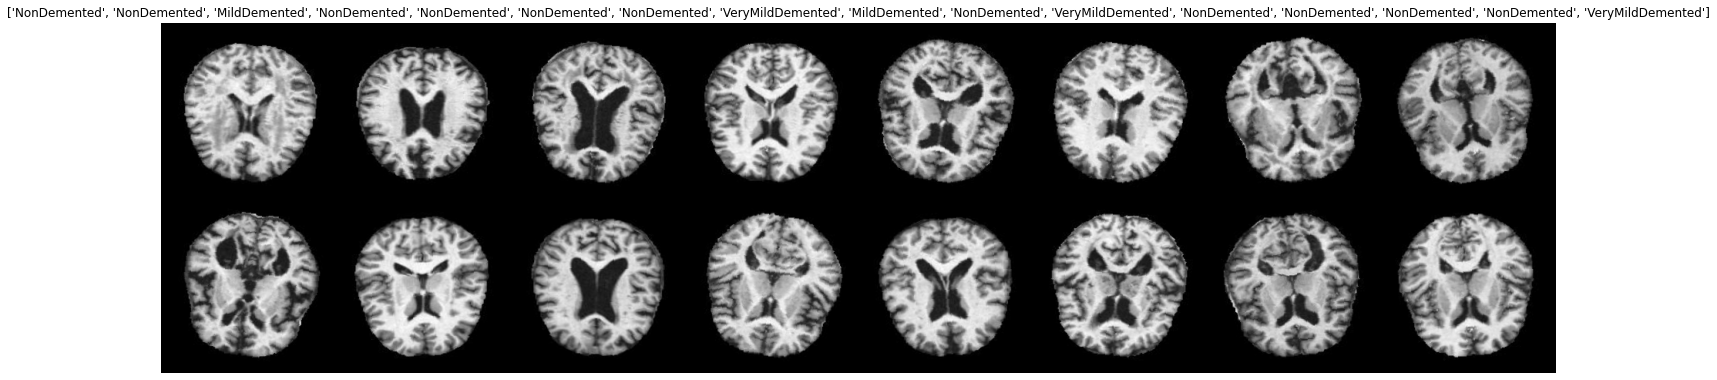

Ground truth:


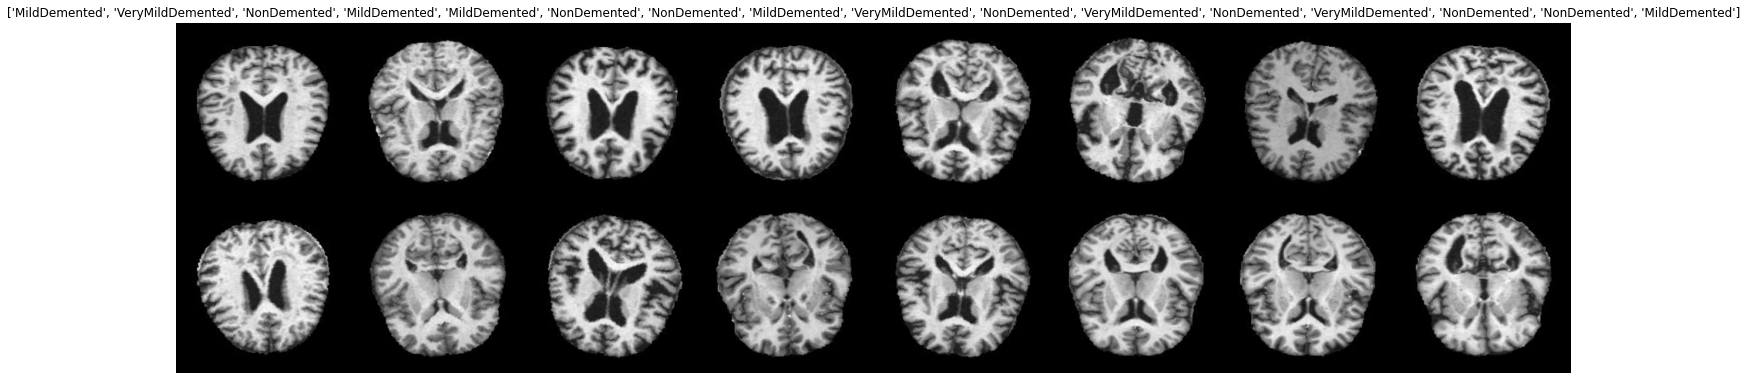

Prediction:


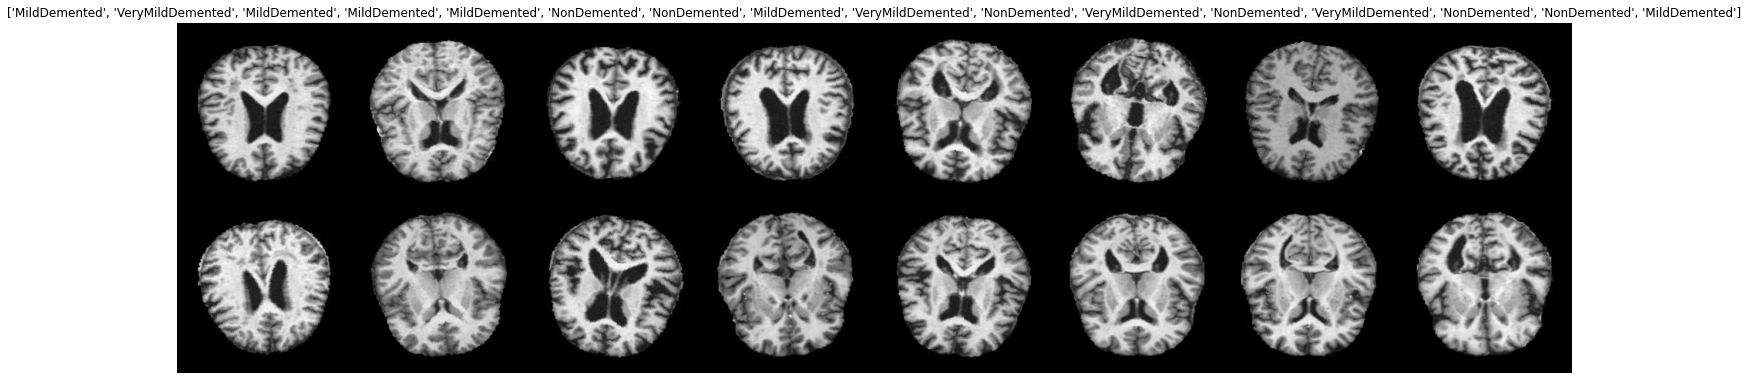

In [ ]:
visualize_model(vgg19, num_images=32)

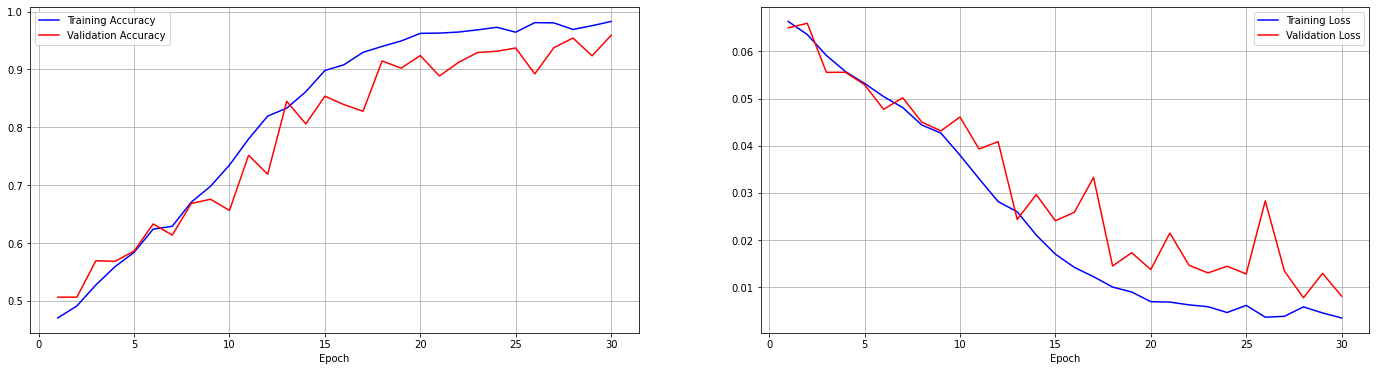

In [ ]:
plot_results(history)